<a href="https://colab.research.google.com/github/jsdysw/Boostcamp-AI-Tech-Product-Serving/blob/main/week9/(6%E1%84%80%E1%85%A1%E1%86%BC_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8_3)_BERT_%E1%84%80%E1%85%B5%E1%84%87%E1%85%A1%E1%86%AB_%E1%84%83%E1%85%AE_%E1%84%86%E1%85%AE%E1%86%AB%E1%84%8C%E1%85%A1%E1%86%BC_%E1%84%80%E1%85%AA%E1%86%AB%E1%84%80%E1%85%A8_%E1%84%87%E1%85%AE%E1%86%AB%E1%84%85%E1%85%B2_%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%92%E1%85%A1%E1%86%A8%E1%84%89%E1%85%B3%E1%86%B8_BERT_IRQA_%E1%84%8E%E1%85%A2%E1%86%BA%E1%84%87%E1%85%A9%E1%86%BA_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT IRQA 기반의 챗봇 실습

> 작성자      
```
* 김성현 (bananaband657@gmail.com)  
1기 멘토
김바다 (qkek983@gmail.com)
박상희 (parksanghee0103@gmail.com)  
이정우 (jungwoo.l2.rs@gmail.com)
2기 멘토
박상희 (parksanghee0103@gmail.com)  
이정우 (jungwoo.l2.rs@gmail.com)
이녕우 (leenw2@gmail.com)
박채훈 (qkrcogns2222@gmail.com)
3, 4, 5, 6기 멘토
이녕우 (leenw2@gmail.com)
박채훈 (qkrcogns2222@gmail.com)
```
[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

### 실습 개요
이번에는 앞서 실습한 두 모델을 합쳐서 IRQA 기반의 챗봇을 만들어보도록 하겠습니다.

### 실습 진행 목적 및 배경
유사도 기반의 자연어처리 프레임워크의 실제 동작 과정을 자세히 살펴봅니다.

### 실습 수행으로 얻어갈 수 있는 역량
IRQA 챗봇 구현을 위한 자연어 전처리, 모델 학습 및 추론을 할 수 있습니다.

### Required Package
- transformers
- accelerate>=0.20.1

본 실습에서는 챗봇 학습용으로 공개된 Chatbot_data_for_Korean 데이터셋을 활용하며,  [링크](https://github.com/songys/Chatbot_data)에서 받으실 수 있습니다.


본 데이터셋은 다음의 [라이센스](https://github.com/songys/Chatbot_data/blob/master/LICENSE)를 따릅니다.

In [ ]:
!git clone https://github.com/songys/Chatbot_data.git

fatal: destination path 'Chatbot_data' already exists and is not an empty directory.


In [ ]:
import pandas as pd
data = pd.read_csv('/content/Chatbot_data/ChatbotData.csv')

In [ ]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


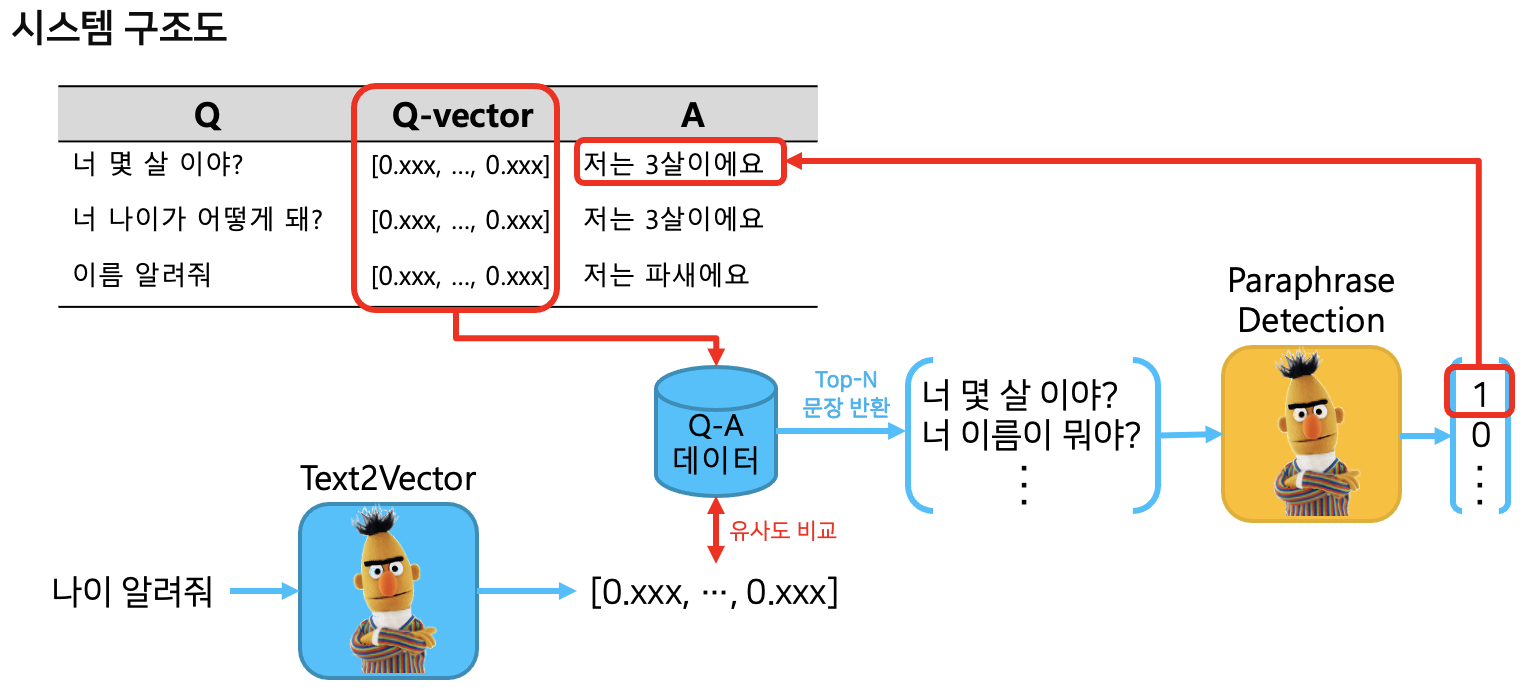

위 그림과 같은 구조도를 구성하기 위해, 먼저 Top-n개 후보를 추출하는 모듈을 구성해보겠습니다.

## Top-n 추출 모듈

In [ ]:
!pip install transformers==4.9.2
!pip install accelerate>=0.20.1

     |████████████████████████████████| 2.6 MB 12.5 MB/s 
     |████████████████████████████████| 636 kB 47.8 MB/s 
     |████████████████████████████████| 3.3 MB 53.7 MB/s 
     |████████████████████████████████| 895 kB 53.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
chatbot_Question = data['Q'].values
chatbot_Answer = data['A'].values
print(chatbot_Question[0:3])
print(chatbot_Answer[0:3])

['12시 땡!' '1지망 학교 떨어졌어' '3박4일 놀러가고 싶다']
['하루가 또 가네요.' '위로해 드립니다.' '여행은 언제나 좋죠.']


### [CLS] token을 얻기 위한 함수

In [ ]:
def get_cls_token(sent_A):
    model.eval()
    tokenized_sent = tokenizer(
            sent_A,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=32
    ).to(device)
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )
    logits = outputs.last_hidden_state[:,0,:].detach().cpu().numpy()
    return logits

전체 질문에 대한 vector 정보를 저장하도록 하겠습니다.

In [ ]:
chatbot_Question_vectors = {}
for i, question in enumerate(chatbot_Question):
    chatbot_Question_vectors[i] = get_cls_token(question)

이제 전체 질문과 유사도를 검사해서 top-n개를 반환하는 코드를 작성해보겠습니다.

In [ ]:
import numpy as np

In [ ]:
def custom_cosine_similarity(a,b):
    numerator = np.dot(a,b.T)
    a_norm = np.sqrt(np.sum(a * a))
    b_norm = np.sqrt(np.sum(b * b, axis=-1))

    denominator = a_norm * b_norm
    return numerator/denominator

In [ ]:
def return_top_n_idx(question, n):
    question_vector = get_cls_token(question)
    sentence_similarity = {}
    for i in chatbot_Question_vectors.keys():
        ir_vector = chatbot_Question_vectors[i]
        similarity = custom_cosine_similarity(question_vector, ir_vector)
        sentence_similarity[i] = similarity

    sorted_sim = sorted(sentence_similarity.items(), key=lambda x: x[1], reverse=True)
    return sorted_sim[0:n]

In [ ]:
print(return_top_n_idx("오늘 너무 힘들어", 5))  # top 5개 question id를 반환합니다.

[(3285, array([[0.97600377]], dtype=float32)), (7121, array([[0.9664848]], dtype=float32)), (5947, array([[0.9598295]], dtype=float32)), (5959, array([[0.95737875]], dtype=float32)), (7176, array([[0.9529198]], dtype=float32))]


In [ ]:
print('most similar questions')
for result in return_top_n_idx("오늘 너무 힘들어", 5):
    print(chatbot_Question[result[0]])
print('\nmost similar answers')
for result in return_top_n_idx("오늘 너무 힘들어", 5):
    print(chatbot_Answer[result[0]])

most similar questions
오늘 너무 힘들다
오늘 너무 힘드네
너무 힘들어
너무나도 힘들어
오늘따라 너무 힘드네

most similar answers
고생 많았어요.
오늘은 힘내려 하지 말아요. 저에게 기대세요.
지금 무슨 말을 해도 와닿지 않겠지만 잘할 수 있을 거예요.
억지로라도 긍정적인 생각을 해보세요.
힘든 날이네요.


하지만 Top-1의 결과가 정답이 아닌 경우도 있습니다.

In [ ]:
print('most similar questions')
for result in return_top_n_idx("너 이름이 뭐야?", 5):
    print(chatbot_Question[result[0]])
print('\nmost similar answers')
for result in return_top_n_idx("너 이름이 뭐야?", 5):
    print(chatbot_Answer[result[0]])

most similar questions
우정이 뭐야?
너 뭐니?
할 줄 아는거 뭐야?
사랑의 끝이 뭐야?
너 누구?

most similar answers
힘들 때 같이 있는 거요.
저는 위로봇입니다.
당신의 삶을 응원해 드릴 수 있어요라고 감히 말해 봅니다.
사랑하지 않는 것이죠.
저는 마음을 이어주는 위로봇입니다.


## 이진 분류 모델

먼저 앞서서 학습한 문장 분류 모델을 load하겠습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from transformers import BertForSequenceClassification

MODEL_NAME = "/content/drive/MyDrive/P_KLUE/baseline_model/bert_two_sent_classifier"
classifier_model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
classifier_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# predict함수
# 0: "non_similar", 1: "similar"
def sentences_predict(sent_A, sent_B):
    classifier_model.eval()
    tokenized_sent = tokenizer(
            sent_A,
            sent_B,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=64
    )

    tokenized_sent.to('cuda:0')
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = classifier_model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)

    # if result == 0:
    #   result = 'non_similar'
    # elif result == 1:
    #   result = 'similar'
    return result

In [ ]:
print(sentences_predict('오늘 날씨가 어때요?','오늘의 날씨를 알려줘')) # similar
print(sentences_predict('오늘 날씨가 어때요?','기분 진짜 안좋다.')) # non_similar
print(sentences_predict('오늘 날씨가 어때요?','오늘 기분 어떠세요?')) # non_similar
print(sentences_predict('오늘 날씨가 어때요?','오늘 기분이 어때요?')) # non_similar
print(sentences_predict('오늘 날씨가 어때요?','지금 날씨가 어때요?')) # non_similar
print(sentences_predict('무협 소설 추천해주세요.','무협 장르의 소설 추천 부탁드립니다.')) # similar
print(sentences_predict('무협 소설 추천해주세요.','판타지 소설 추천해주세요.')) # non_similar
print(sentences_predict('무협 소설 추천해주세요.','무협 느낌나는 소설 하나 추천해주실 수 있으실까요?')) # similar
print(sentences_predict('메난민이 뭐야','너 메난민이지?')) # similar

1
0
0
0
0
1
0
1
1


그럼 마지막으로 top_n개의 문장을 입력으로 받으면   
가장 적절한 문장을 반환하는 함수를 작성하겠습니다.    

In [ ]:
def get_answer(question, n):
    results = return_top_n_idx(question, n) # top n개를 list로 받고
    for result in results:  # n개를 반복문을 돌면서
        ir_answer = chatbot_Answer[result[0]]
        ir_question = chatbot_Question[result[0]]
        if sentences_predict(question, ir_question) == 1:   # 이진분류 모델이 query<->question의 의미가 서로 같다고 판단되면?
            return ir_answer    # 정답을 반환합니다.
    return chatbot_Answer[results[0][0]]    # "잘 모르겠어요."


In [ ]:
print(get_answer("너 이름이 뭐야?", 5))

저는 위로봇입니다.


In [ ]:
print(get_answer("나 지금 너무 우울해", 5))

꼼꼼한 거예요.


In [ ]:
print(get_answer("오늘 기분 어때?", 5))

숨 쉴만 했으면 좋겠네요.


In [ ]:
print(get_answer("바쁜가보네?", 5))

직접 확인해보세요.


In [ ]:
print(get_answer("어떻게 확인하는데?", 5))

잠시 차분하게 생각해봐요.
